<a href="https://colab.research.google.com/github/Firojpaudel/Deepseek_implementation_scratch/blob/main/GQA_model_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@ Imports

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM

<div align="center">
<img src="https://i.postimg.cc/TPMSxjFJ/Screenshot-52.png" width="600px" >
</div>

In [2]:
#@ Model Loading
model_name = "mistralai/Mistral-7B-v0.1"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype= torch.float16,
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [7]:
def viz_gqa_group_mapping(input_text="Hey there! This is Mistral", layer_idx=0):
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    k_values = []

    def capture_k_hook(module, input, output):
        k_values.append(output.detach().cpu())

    handle = model.model.layers[layer_idx].self_attn.k_proj.register_forward_hook(capture_k_hook)

    with torch.no_grad():
        _ = model(**inputs)

    handle.remove()

    keys = k_values[0]
    batch, seq_len, hidden_dim = keys.shape

    n_q = model.config.num_attention_heads
    n_kv = model.config.num_key_value_heads
    head_dim = hidden_dim // n_kv

    keys = keys.view(batch, seq_len, n_kv, head_dim)
    keys_first = keys[0, 0].numpy()

    group_size = n_q // n_kv

    labels = []
    expanded_keys = []
    for g in range(n_kv):
        for q in range(group_size):
            labels.append(f"Group {g} - Q{q}")
            expanded_keys.append(keys_first[g])  # same KV shared across queries

    expanded_keys = np.array(expanded_keys)

    plt.figure(figsize=(12, 8))
    sns.heatmap(expanded_keys, cmap="viridis", yticklabels=labels)
    plt.title(f"GQA Key Groups Expanded into Queries | Layer {layer_idx}")
    plt.xlabel("Head Dimension")
    plt.ylabel("Query Heads (Grouped)")
    plt.show()

    return expanded_keys, labels

In [8]:
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.metrics.pairwise import cosine_similarity

def viz_gqa_group_mapping_clustered(input_text="Hey there! This is Mistral", layer_idx=0):
    expanded_keys, labels = viz_gqa_group_mapping(input_text, layer_idx)

    # Cosine similarity matrix
    sim_matrix = cosine_similarity(expanded_keys)

    # Hierarchical clustering
    linkage_matrix = linkage(sim_matrix, method="average")
    ordered_idx = leaves_list(linkage_matrix)

    # Reorder keys and labels
    clustered_keys = expanded_keys[ordered_idx]
    clustered_labels = [labels[i] for i in ordered_idx]

    plt.figure(figsize=(12, 8))
    sns.heatmap(clustered_keys, cmap="viridis", yticklabels=clustered_labels)
    plt.title(f"GQA Keys (Clustered by Similarity) | Layer {layer_idx}")
    plt.xlabel("Head Dimension")
    plt.ylabel("Clustered Query Heads")
    plt.show()

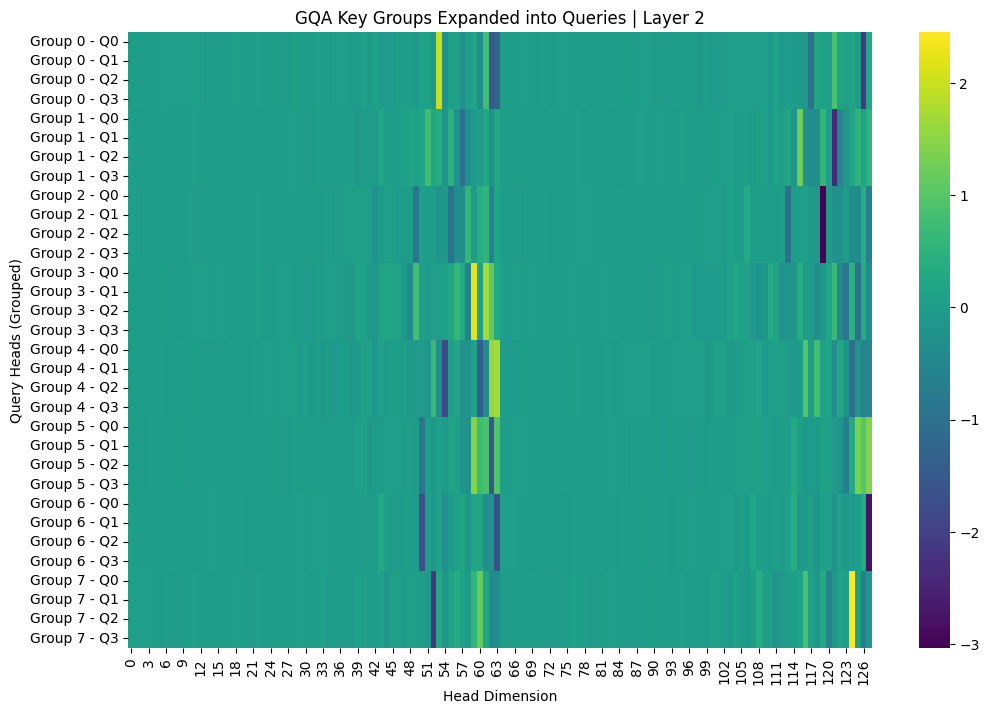

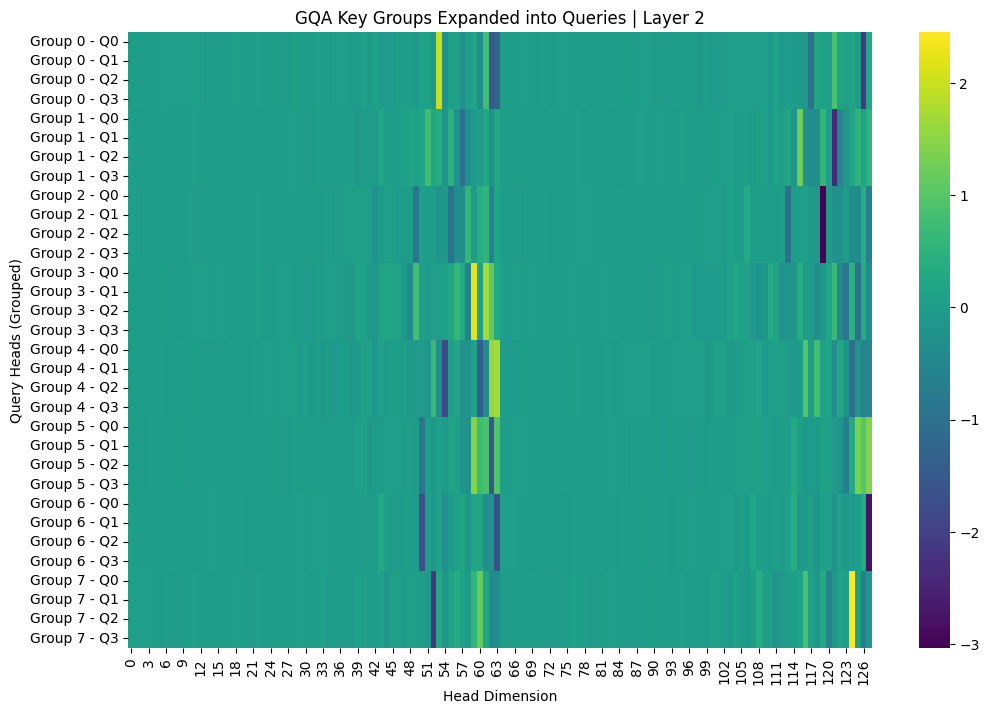

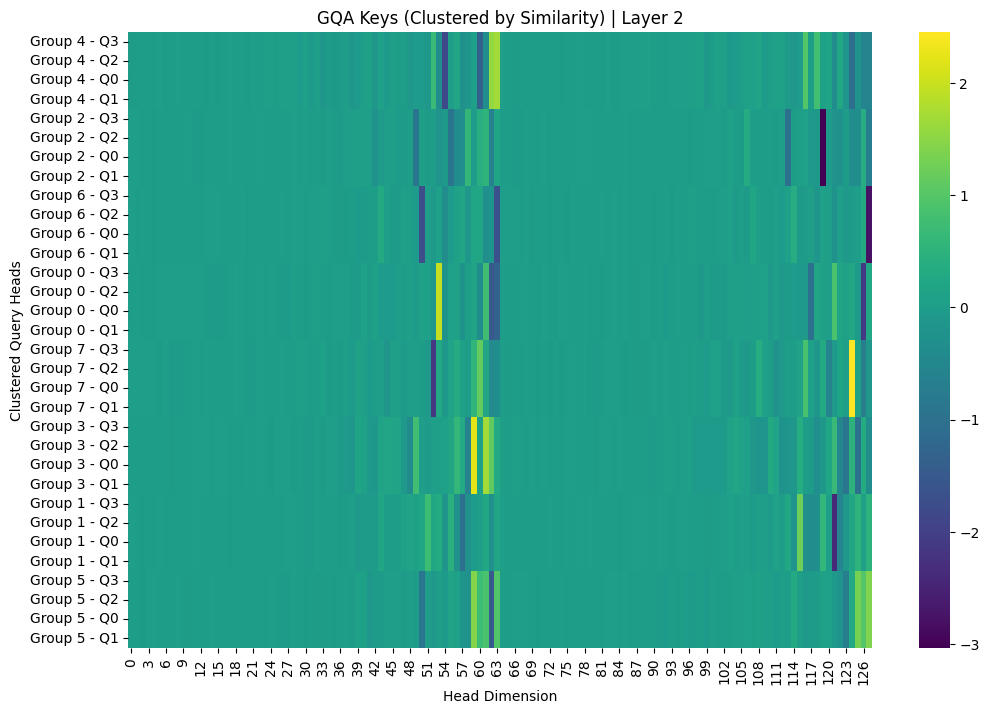

In [9]:
if __name__ == "__main__":
    text = "The quick brown fox jumps over the lazy dog"
    layer = 2

    # Expanded view (Q→KV mapping)
    viz_gqa_group_mapping(text, layer)

    # Clustered view (similar heads grouped together)
    viz_gqa_group_mapping_clustered(text, layer)
